In [ ]:
!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)

class EENet(nn.Module):
    def __init__(self, in_channels=3, base_channels=32):
        super(EENet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.res1 = ResidualBlock(base_channels)
        self.conv2 = nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1)
        self.res2 = ResidualBlock(base_channels*2)
        self.res3 = ResidualBlock(base_channels*2)
        self.res4 = ResidualBlock(base_channels*2)
        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 4, stride=2, padding=1)
        self.res5 = ResidualBlock(base_channels)
        self.final = nn.Conv2d(base_channels, in_channels, 3, padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x1 = self.res1(x1)
        x2 = F.relu(self.conv2(x1))
        x2 = self.res2(x2)
        x2 = self.res3(x2)
        x2 = self.res4(x2)
        x3 = F.relu(self.up1(x2))
        x3 = self.res5(x3)
        out = self.final(x3)
        return torch.sigmoid(out)


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class DehazingDataset(Dataset):
    def __init__(self, hazy_dir, clean_dir, transform=None):
        self.hazy_dir = hazy_dir
        self.clean_dir = clean_dir
        self.filenames = sorted(os.listdir(hazy_dir))
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.filenames[idx])
        clean_path = os.path.join(self.clean_dir, self.filenames[idx])
        hazy_img = Image.open(hazy_path).convert("RGB")
        clean_img = Image.open(clean_path).convert("RGB")

        if self.transform:
            hazy_img = self.transform(hazy_img)
            clean_img = self.transform(clean_img)

        return hazy_img, clean_img

# Paths
hazy_dir = "/content/drive/MyDrive/RB-Dust/with"
clean_dir = "/content/drive/MyDrive/RB-Dust/without"

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and Dataloader
dataset = DehazingDataset(hazy_dir, clean_dir, transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EENet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for hazy, clean in train_loader:
        hazy, clean = hazy.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(hazy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/50], Loss: 0.6088
Epoch [2/50], Loss: 0.4292
Epoch [3/50], Loss: 0.3648
Epoch [4/50], Loss: 0.3248
Epoch [5/50], Loss: 0.3070
Epoch [6/50], Loss: 0.2772
Epoch [7/50], Loss: 0.2723
Epoch [8/50], Loss: 0.2587
Epoch [9/50], Loss: 0.2478
Epoch [10/50], Loss: 0.2496
Epoch [11/50], Loss: 0.2356
Epoch [12/50], Loss: 0.2300
Epoch [13/50], Loss: 0.2292
Epoch [14/50], Loss: 0.2228
Epoch [15/50], Loss: 0.2306
Epoch [16/50], Loss: 0.2201
Epoch [17/50], Loss: 0.2172
Epoch [18/50], Loss: 0.2182
Epoch [19/50], Loss: 0.2150
Epoch [20/50], Loss: 0.2106
Epoch [21/50], Loss: 0.2137
Epoch [22/50], Loss: 0.2182
Epoch [23/50], Loss: 0.2229
Epoch [24/50], Loss: 0.2058
Epoch [25/50], Loss: 0.2023
Epoch [26/50], Loss: 0.2024
Epoch [27/50], Loss: 0.2115
Epoch [28/50], Loss: 0.2001
Epoch [29/50], Loss: 0.2031
Epoch [30/50], Loss: 0.2152
Epoch [31/50], Loss: 0.2003
Epoch [32/50], Loss: 0.2081
Epoch [33/50], Loss: 0.1964
Epoch [34/50], Loss: 0.2061
Epoch [35/50], Loss: 0.2054
Epoch [36/50], Loss: 0.1976
E

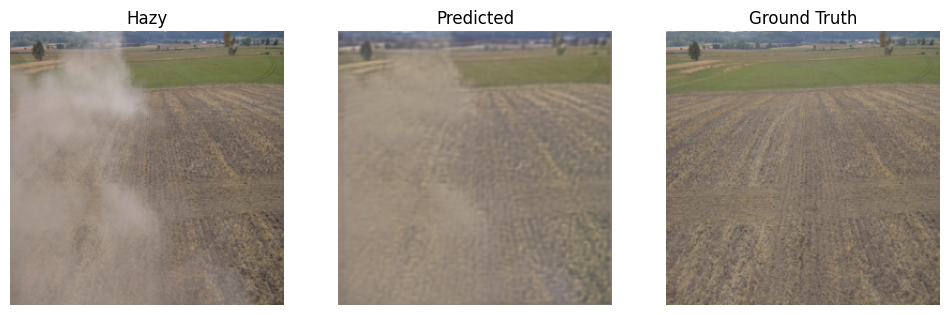

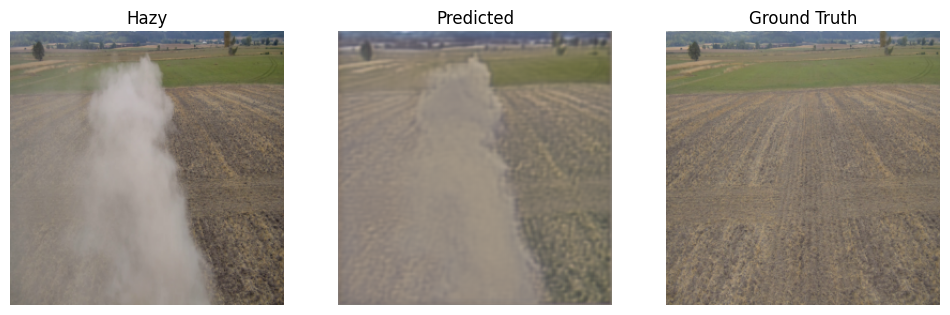

In [ ]:
# Show a sample result
model.eval()
with torch.no_grad():
    hazy, clean = next(iter(train_loader))
    hazy = hazy.to(device)
    output = model(hazy).cpu()

for i in range(2):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(hazy[i].cpu().permute(1, 2, 0))
    axs[0].set_title("Hazy")
    axs[1].imshow(output[i].permute(1, 2, 0))
    axs[1].set_title("Predicted")
    axs[2].imshow(clean[i].permute(1, 2, 0))
    axs[2].set_title("Ground Truth")
    for ax in axs:
        ax.axis("off")
    plt.show()


In [ ]:
import torch.nn.functional as F
import math

def calculate_psnr(pred, target, max_pixel=1.0):
    mse = F.mse_loss(pred, target)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(max_pixel) - 10 * math.log10(mse.item())
    return psnr


In [ ]:
model.eval()
total_psnr = 0
count = 0

with torch.no_grad():
    for hazy, clean in train_loader:
        hazy, clean = hazy.to(device), clean.to(device)
        output = model(hazy)

        for i in range(hazy.size(0)):
            psnr_val = calculate_psnr(output[i], clean[i])
            total_psnr += psnr_val
            count += 1

avg_psnr = total_psnr / count
print(f"📊 Average PSNR: {avg_psnr:.2f} dB")


📊 Average PSNR: 25.09 dB
